# Basic notebook info

ENG: This notebook is used for FER-model loading and fine-tuning. I used pre-trained VGGFace on ResNET-50, with one hidden layer on 512 neurons and final dense layer with 9 outputs. Only 13 last layers in VGGFace are trainable. In train and validation datasets I added augmentation with brightness, shear, zoom and flip modification.

RU: Данный ноутбук использов для загрузки и дообучения модели распознавания лицевых эмоций. Я использоловал предобученную сеть VGGFace на базе ResNET-50, добавив к ней один скрытый слой на 512 нейронов, и один выходной слой на 9 нейронов (по количеству типов эмоций в датасете). В исходной сети только последние 13 слоев разморожены. В обучающем и валидационном датасете я использовал аугментацию по яркости, деформации, масштабу и отражению.

# Dependenices installation

In [1]:
!pip install keras_vggface
!pip install livelossplot
!pip install keras_applications --no-deps


# Library import

In [31]:
import numpy as np
import tensorflow as tf
import pandas as pd

from tensorflow.keras.models import model_from_json

from tensorflow import keras
from PIL import Image
from livelossplot.tf_keras import PlotLossesCallback
from keras_vggface.vggface import VGGFace

import matplotlib.pyplot as plt
from keras_vggface import utils

from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
# from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras_vggface.utils import preprocess_input as preprocess_input_vggface

%matplotlib inline


# Load dataset and split validation part

In [32]:
# load csv with images
df = pd.read_csv('./_datasets/train.csv', index_col = 0)
# edit path to file location
df['image_path'] = df['image_path'].apply(lambda x: str.replace(x, 'train', '_datasets/train_dataset'))

train_df = df.sample(frac=0.8,random_state=200)
test_df = df.drop(train_df.index)

# Image generators with augmentation

In [33]:
def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface
    """
    preprocessed = utils.preprocess_input(image_, version=2)
    
    return preprocessed

In [34]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
N_CLASSES = 9

# train generator with augmentation
train_generator = ImageDataGenerator(
                                     rotation_range=15,
                                     horizontal_flip=True,
                                     fill_mode='nearest',
                                     brightness_range=(0.5,1.5),
                                     shear_range=0.1,
                                     zoom_range=.1,
                                     preprocessing_function=preprocess_input_facenet)
        
train_data_gen = train_generator.flow_from_dataframe(dataframe=train_df,
                                                     x_col='image_path',
                                                     y_col='emotion',
                                                     target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='sparse',
                                                     shuffle=True,
                                                     interpolation='nearest',
                                                )

# validation generator without augmentation
val_generator = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

val_data_gen = val_generator.flow_from_dataframe(dataframe=test_df,
                                                 x_col='image_path',
                                                 y_col='emotion',
                                                 target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='sparse',
                                                 shuffle=False,
                                                 interpolation='nearest',
                                                )

Found 40037 validated image filenames belonging to 9 classes.
Found 10009 validated image filenames belonging to 9 classes.


# VGGFace load and final model set-up

In [35]:
# Load VGGFace model with RESNet
vggface_model = VGGFace(model='resnet50', include_top=False,
                        input_shape=(224, 224, 3))
vggface_model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [36]:
model = tf.keras.Sequential([
    vggface_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9)])
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Functional (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 4617      
Total params: 24,614,857
Trainable params: 24,561,737
Non-trainable params: 53,120
_________________________________________________________________


# Load of existing network

In [6]:
# uncomment code below to use existing model and weights

# with open("./_models/emotion_classification/model.json", 'r') as json_file:
#     loaded_model_json = json_file.read()
# model = model_from_json(loaded_model_json)
# model.load_weights("./_models/emotion_classification/saved_weights")

# Final model compile

In [21]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('./_models/_checkpoints/classification/',
                            verbose=1,
                            save_best_only=True,
                            save_weights_only=True,
                            save_freq='epoch',
                            mode='min')

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-4,
    decay_steps=100,
    decay_rate=0.9)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


# Model fitting

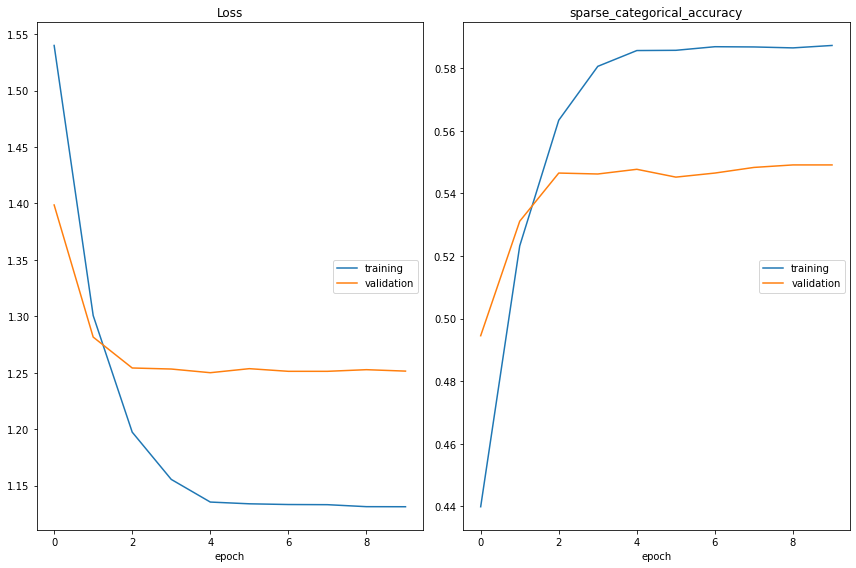

Loss
	training         	 (min:    1.131, max:    1.540, cur:    1.131)
	validation       	 (min:    1.250, max:    1.399, cur:    1.251)
sparse_categorical_accuracy
	training         	 (min:    0.440, max:    0.587, cur:    0.587)
	validation       	 (min:    0.495, max:    0.549, cur:    0.549)
1252/1252 [==============================] - 593s 474ms/step - loss: 1.1313 - sparse_categorical_accuracy: 0.5873 - val_loss: 1.2514 - val_sparse_categorical_accuracy: 0.5491


In [22]:
# train model
EPOCHS = 10
history = model.fit(train_data_gen, epochs=EPOCHS, validation_data=val_data_gen,
                    callbacks=[checkpoint, PlotLossesCallback()])

# Evaluate model

In [23]:
# evaluate model
model.evaluate(val_data_gen)

313/313 [==============================] - 127s 407ms/step - loss: 1.2514 - sparse_categorical_accuracy: 0.5503


[1.2514389753341675, 0.5503147840499878]

# Predicted emotions demonstration

In [24]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) is picture after vgg_preprocessing. 
    It has negative values and matplotlib cannot show it correctly.
    Function returns unprocessed image.

    return: unprocessed image in np.uint8. 
    """
    image = np.copy(vggface_image)
    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912
    image = image[..., ::-1]
    image = image.astype(np.uint8)
    
    return image

In [25]:
def show_faces(images, real_race=None, real_emotion=None, predicted_emotion=None):
    """
    Function shows image from data generator with real and predicted labels
    
    """
    plt.figure(figsize=(10,10))
    labels = {"Emotion": [predicted_emotion, real_emotion]}
    emotion_mapping = dict(list(enumerate(('Anger', 'Contempt',
                    'Disgust', 'Fear',
                    'Happy', 'Neutral',
                    'Sad', 'Surprise', 'Uncertain'))))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            elif name == "Emotion":
                real_emotion = int(real[i])
                predicted_emotion = np.argmax(predicted[i])
                real_str += f"{emotion_mapping[real_emotion]}, "
                pred_str += f"{emotion_mapping[predicted_emotion]}, "
                if real_emotion != predicted_emotion:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')

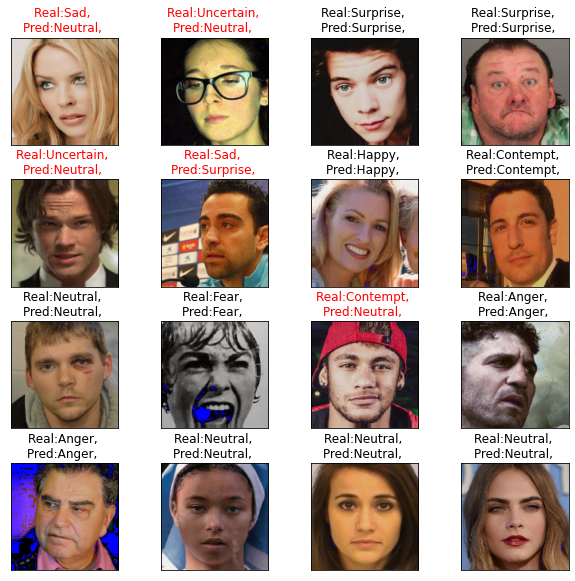

In [30]:
sample_validation_images, sample_validation_labels = next(val_data_gen)
predicted = model.predict(sample_validation_images)
show_faces(sample_validation_images, real_emotion=sample_validation_labels, predicted_emotion=predicted)

# Save model to json with separate weights

In [27]:
model_json = model.to_json()
with open("./_models/emotion_classification/model.json","w") as json_file:
    json_file.write(model_json)

In [28]:
model.save_weights('./_models/emotion_classification/saved_weights')